# Scripts to build
* Extract values from Atlas
* Convert to probabilities
* Prepare inputs after masking
* Generate results

In [34]:
import os
import pandas
import numpy as np
import nibabel as ni
from glob import glob
import statsmodels.distributions.empirical_distribution as ed
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.io import savemat,loadmat
from matplotlib import mlab
from sklearn.mixture import GaussianMixture
from statsmodels.sandbox.stats.multicomp import multipletests

### Testing Extract Values from Atlas

In [65]:
files_in = '/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/smoothed_wscored_scans/'
atlas = '/home/users/jvogel/Science/templates/atlases/Lund/hippocampus_labels_LUND_scif55_1p5.nii.gz'


In [66]:
%%time
df = Extract_Values_from_Atlas(files_in,atlas)

It seems you passed a directory
found 238 images!
working on subject 0
working on subject 1
working on subject 2
working on subject 3
working on subject 4
working on subject 5
working on subject 6
working on subject 7
working on subject 8
working on subject 9
working on subject 10
working on subject 11
working on subject 12
working on subject 13
working on subject 14
working on subject 15
working on subject 16
working on subject 17
working on subject 18
working on subject 19
working on subject 20
working on subject 21
working on subject 22
working on subject 23
working on subject 24
working on subject 25
working on subject 26
working on subject 27
working on subject 28
working on subject 29
working on subject 30
working on subject 31
working on subject 32
working on subject 33
working on subject 34
working on subject 35
working on subject 36
working on subject 37
working on subject 38
working on subject 39
working on subject 40
working on subject 41
working on subject 42
working on sub

In [69]:
%%time
df = Extract_Values_from_Atlas(files_in,atlas,blocking='all_at_once')

It seems you passed a directory
found 238 images!
extracting values from atlas
CPU times: user 9.42 s, sys: 13.2 s, total: 22.6 s
Wall time: 1min 38s


In [95]:
%%time
df = Extract_Values_from_Atlas(files_in,atlas,blocking=100)

It seems you passed a directory
found 238 images!
working on batch 1 of 100 subjects
processing 100 subjects
working on batch 2 of 100 subjects
processing 100 subjects
working on final batch of subjects
processing 38 subjects
CPU times: user 9.38 s, sys: 6.43 s, total: 15.8 s
Wall time: 57.6 s


In [96]:
%%time
df = Extract_Values_from_Atlas(files_in,atlas,blocking=50)

It seems you passed a directory
found 238 images!
working on batch 1 of 50 subjects
processing 50 subjects
working on batch 2 of 50 subjects
processing 50 subjects
working on batch 3 of 50 subjects
processing 50 subjects
working on batch 4 of 50 subjects
processing 50 subjects
working on final batch of subjects
processing 38 subjects
CPU times: user 9.52 s, sys: 4.38 s, total: 13.9 s
Wall time: 46.7 s


In [382]:
files_in = glob('/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/amyloid_positive/*')[:10]
atlas = '/home/users/jvogel/Science/templates/atlases/dkt_atlas_1p5mm.nii'
mask = '/home/users/jvogel/Science/templates/masks/ADNI_GM_mask_1p5mm_nocereb.nii.gz'
df = Extract_Values_from_Atlas(files_in,atlas,blocking='all_at_once')
df.head()


processing 10 subjects
extracting values from atlas


,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_74,roi_75,roi_76,roi_77,roi_78,roi_79,roi_80,roi_81,roi_82,roi_83
0,1.12503,0.96563,1.47036,1.17956,1.21843,1.31315,0.954138,0.930054,1.18229,0.953653,...,1.06754,1.29632,0.18684,1.0625,0.861728,0.0253003,0.0218373,0.00271608,0,0
1,0.846649,0.786214,0.935283,0.920012,1.22136,0.753671,1.03424,0.819864,0.82441,0.836315,...,0.814422,1.07019,0.176426,0.918165,0.718595,0.022491,0.0213802,0.0018803,0,0
2,0.961321,1.38391,1.17448,1.18773,1.21012,1.14372,1.07351,1.10859,0.949484,1.01913,...,1.17601,1.15602,0.199559,1.27251,0.788099,0.0227606,0.0198251,0.00183554,0,0
3,0.799637,0.948868,0.95332,1.24145,1.08986,0.949984,0.97222,0.894087,0.83053,1.00195,...,1.08328,1.12914,0.194576,1.09461,0.743669,0.0213628,0.0203609,0.00132649,0,0
4,0.947092,0.800613,1.0001,0.924523,0.959695,0.973803,0.818108,1.09245,0.779468,0.903535,...,1.18515,1.10634,0.170028,1.01986,0.833708,0.0219119,0.0209345,0.00165586,0,0


In [9]:
files_in = glob('/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/amyloid_positive/*')[:10]
atlas = '/home/users/jvogel/Science/templates/atlases/dkt_atlas_1p5mm.nii'
mask = '/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/tau_positive_mask.nii.gz'
df = Extract_Values_from_Atlas(files_in,atlas,blocking='all_at_once', mask=mask)


NameError: name 'Extract_Values_from_Atlas' is not defined

In [380]:
df

,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_74,roi_75,roi_76,roi_77,roi_78,roi_79,roi_80,roi_81,roi_82,roi_83
0,0,0.467798,0,0.162092,0.289008,0.0624374,0.29161,0.170493,0.00487941,0.0126394,...,0,0.10965,0,0,0,0.00241662,0.00256458,0,0,0
1,0,0.360601,0,0.110073,0.25102,0.0172521,0.360672,0.157173,0.00395247,0.00743246,...,0,0.0872519,0,0,0,0.00222852,0.00298434,0,0,0
2,0,0.694473,0,0.184552,0.282964,0.0423258,0.358043,0.229554,0.00793952,0.0150604,...,0,0.110011,0,0,0,0.00232462,0.00228424,0,0,0
3,0,0.443139,0,0.176017,0.262797,0.0407669,0.332387,0.158285,0.00468573,0.0165842,...,0,0.108085,0,0,0,0.00231435,0.00267445,0,0,0
4,0,0.372809,0,0.130706,0.221352,0.0309091,0.217758,0.17439,0.00637958,0.00852364,...,0,0.0858672,0,0,0,0.0023377,0.0024275,0,0,0
5,0,0.425915,0,0.219874,0.278698,0.0416333,0.292827,0.202178,0.0095961,0.0129884,...,0,0.126646,0,0,0,0.00277987,0.00259946,0,0,0
6,0,0.35873,0,0.238324,0.256773,0.046447,0.227677,0.159794,0.00596464,0.0166324,...,0,0.100628,0,0,0,0.00231957,0.00256837,0,0,0
7,0,0.464086,0,0.154481,0.233083,0.0509481,0.279863,0.160705,0.0075686,0.0139782,...,0,0.105362,0,0,0,0.0023201,0.00241522,0,0,0
8,0,0.521866,0,0.100456,0.232791,0.0496634,0.263165,0.237665,0.00675556,0.0113364,...,0,0.0987783,0,0,0,0.00224878,0.00259606,0,0,0
9,0,0.348633,0,0.123892,0.245587,0.0499846,0.298569,0.122475,0.00719223,0.0110767,...,0,0.0738803,0,0,0,0.00241823,0.00230863,0,0,0


In [11]:
files_in = glob('/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/amyloid_positive/*')[:10]
atlas = '/home/users/jvogel/Science/templates/atlases/dkt_atlas_1p5mm.nii'
mask = '/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/tau_positive_mask.nii.gz'
df = Extract_Values_from_Atlas(files_in,atlas,blocking='all_at_once', mask=mask, mask_threshold=100)
df.head()

processing 10 subjects
masking...
extracting values from atlas


,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_74,roi_75,roi_76,roi_77,roi_78,roi_79,roi_80,roi_81,roi_82,roi_83
0,0,0.467798,0,0.162092,0.289008,0.0624374,0.29161,0.170493,0,0,...,0,0.10965,0,0,0,0,0,0,0,0
1,0,0.360601,0,0.110073,0.25102,0.0172521,0.360672,0.157173,0,0,...,0,0.0872519,0,0,0,0,0,0,0,0
2,0,0.694473,0,0.184552,0.282964,0.0423258,0.358043,0.229554,0,0,...,0,0.110011,0,0,0,0,0,0,0,0
3,0,0.443139,0,0.176017,0.262797,0.0407669,0.332387,0.158285,0,0,...,0,0.108085,0,0,0,0,0,0,0,0
4,0,0.372809,0,0.130706,0.221352,0.0309091,0.217758,0.17439,0,0,...,0,0.0858672,0,0,0,0,0,0,0,0


In [431]:
files_in = glob('/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/amyloid_positive/*')[:10]
atlas = '/home/users/jvogel/Science/templates/atlases/dkt_atlas_1p5mm.nii'
mask = '/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/tau_positive_mask.nii.gz'
df = Extract_Values_from_Atlas(files_in,atlas,blocking=5, mask=mask, mask_threshold=100)
df

processing 10 subjects
working on batch 1 of 5 subjects
processing 5 subjects
working on batch 2 of 5 subjects
processing 5 subjects


,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_74,roi_75,roi_76,roi_77,roi_78,roi_79,roi_80,roi_81,roi_82,roi_83
0,0,0.467798,0,0.162092,0.289008,0.0624374,0.29161,0.170493,0,0,...,0,0.10965,0,0,0,0,0,0,0,0
1,0,0.360601,0,0.110073,0.25102,0.0172521,0.360672,0.157173,0,0,...,0,0.0872519,0,0,0,0,0,0,0,0
2,0,0.694473,0,0.184552,0.282964,0.0423258,0.358043,0.229554,0,0,...,0,0.110011,0,0,0,0,0,0,0,0
3,0,0.443139,0,0.176017,0.262797,0.0407669,0.332387,0.158285,0,0,...,0,0.108085,0,0,0,0,0,0,0,0
4,0,0.372809,0,0.130706,0.221352,0.0309091,0.217758,0.17439,0,0,...,0,0.0858672,0,0,0,0,0,0,0,0
5,0,0.425915,0,0.219874,0.278698,0.0416333,0.292827,0.202178,0,0,...,0,0.126646,0,0,0,0,0,0,0,0
6,0,0.35873,0,0.238324,0.256773,0.046447,0.227677,0.159794,0,0,...,0,0.100628,0,0,0,0,0,0,0,0
7,0,0.464086,0,0.154481,0.233083,0.0509481,0.279863,0.160705,0,0,...,0,0.105362,0,0,0,0,0,0,0,0
8,0,0.521866,0,0.100456,0.232791,0.0496634,0.263165,0.237665,0,0,...,0,0.0987783,0,0,0,0,0,0,0,0
9,0,0.348633,0,0.123892,0.245587,0.0499846,0.298569,0.122475,0,0,...,0,0.0738803,0,0,0,0,0,0,0,0


In [10]:
def Extract_Values_from_Atlas(files_in, atlas, 
                              mask = None, mask_threshold = 0,
                              blocking = 'one_at_a_time', 
                              labels = [], sids = [], 
                              output = None,):
    '''
    This function will extract mean values from a set of images for 
    each ROI from a given atlas. Returns a Subject x ROI pandas
    DataFrame (and csv file if output argument is set to a path).
    
    Use blocking argument according to memory capacity of your
    computer vis-a-vis memory requirements of loading all images.
    
    files_in: determines which images to extract values from. Input 
    can be any of the following:
        -- a list of paths
        -- a path to a directory containing ONLY files to extract from
        -- a search string (with wild card) that would return all
        desired images. For example, doing ls [files_in] in a terminal 
        would list all desired subjects
        -- a 4D Nifti image
        **NOTE** be aware of the order of file input, which relates to 
        other arguments
        
    atlas: Path to an atlas, or a Nifti image or np.ndarry of desired 
    atlas. Or, if doing native space analysis, instead, supply a list 
    of paths to atlases that match each subject. 
        NOTE: In this case, The order of this list should be the same
        order as subjects in files_in
    
    mask: Path to a binary inclusive mask image. Script will set all 
    values to 0 for every image where mask voxels = 0. This process
    is done before extraction. If doing a native space analysis,
    instead, supply a list of paths to masks that match each subject
    and each atlas.
    
    mask_threshold: An integer that denotes the minimum acceptable
    size (in voxels) of an ROI after masking. This is to prevent
    tiny ROIs resulting from conservative masks that might have
    spuriously high or low mean values due to the low amount of
    information within.
    
    blocking: loading all images to memory at once may not be possible
    depending on your computer. Acceptable arguments are:
        -- 'one_at_a_time': will extract values from each image
        independently. Recommended for memories with poor memory 
        capacity. Required for native space extraction.
        -- 'all_at_once': loads all images into memory at once.
        Provides a slight speed up for faster machines overe
        one_at_a_time, but is probably not faster than batching (see
        below). Only recommended for smaller datasets.
        ** WARNING ** Not recommended on very large datasets. Will
        crash computers with poor memory capacity.
        -- any integer: determines the number of images to be read to
        memory at once. Recommended for large datasets. 
    
    labels: a list of string labels that represent the names of the
    ROIs from atlas. 
        NOTE: ROIs are read consecutively from lowest to highest, and
        labels *must* match that order
    Default argument [] will use "ROI_x" for each ROI, where X
    corresponds to the actual ROI integer lael
    
    sids: a list of subject IDs in the same order as files_in. Default 
    argument [] will list subjects with consecutive integers.
    
    output: if you wish the resulting ROI values to be written to file,
    provide a FULL path. Otherwise, leave as None (matrix will be 
    returned)
    
    '''
    
    if type(blocking) == str and blocking not in ['all_at_once','one_at_a_time']:
        raise IOError('blocking only accepts integers or argumennts of "all_at_once" or "one_at_a_time"')
    
    if type(atlas) == list: 
        if blocking != 'one_at_a_time':
            print('WARNING: you have passed a list of atlases but blocking is not set to one_at_a_time')
            print('Lists of atlases are for native space situations where each subject has their own atlas')
            print('If you want to test multiple atlases, run the script multiple times with different atlases')
            raise IOError('you have passed a list of atlases but blocking is not set to one_at_a_time')
    
    if type(mask) != type(None):
        if type(atlas) != type(mask):
            raise IOError('for masking, list of masks must be passed that equals length of atlas list')
        elif type(mask) == list:
            if len(atlas) != len(mask):
                raise IOError('list of atlases (n=%s) and masks (n=%s) are unequal'%(len(atlases),
                                                                                    len(masks)))
        
    if type(atlas) != list:
        if type(atlas) == str:
            try:
                atl = ni.load(atlas).get_data()
            except:
                raise IOError('could not find an atlas at the specified location: %s'%atlas)
        elif type(atlas) == ni.nifti1.Nifti1Image:
            atl = atlas.get_data()
        elif type(atlas) == np.ndarray:
            atl = atlas
        else:
            print('could not recognize atlas filetype. Please provide a path, a NiftiImage object, or an numpy ndarray')
            raise IOError('atlas type not recognized')
        
        if blocking == 'all_at_once':
            i4d = load_data(files_in, return_images=True).get_data()
            if i4d.shape[:-1] != atl.shape:
                raise IOError('image dimensions do not match atlas dimensions')
            if type(mask) != type(None):
                print('masking...')
                mask_data = ni.load(mask).get_data()
                mask_data = mask_atlas(mask_data, atl, mask_threshold)
                i4d = mask_image_data(i4d, mask_data)
            if len(sids) == 0:
                sids = range(i4d.shape[-1])
            print('extracting values from atlas')
            roi_vals = generate_matrix_from_atlas(i4d, atl, labels, sids)
        else:
            image_paths = load_data(files_in, return_images = False)
            if blocking == 'one_at_a_time':
                catch = []
                for i,image_path in enumerate(image_paths):
                    if len(sids) > 0: 
                        sid = [sids[i]]
                    else:
                        sid = [i]
                    print('working on subject %s'%sid[0])
                    img = ni.load(image_path).get_data()
                    try:
                        assert img.shape == atl.shape, 'fail'
                    except:
                        print('dimensions for subject %s (%s) image did not match atlas dimensions (%s)'%(sid,
                                                                                 img.shape,
                                                                                 atl.shape))
                        print('skipping subject %s'%sid[0])
                        continue
                    if type(mask) != type(None):
                        mask_data = ni.load(mask).get_data()
                        mask_data = mask_atlas(mask_data, atl, mask_threshold)
                        img = mask_image_data(img, mask_data)
                    f_mat = generate_matrix_from_atlas(img, atl, labels, sid)
                    catch.append(f_mat)
                roi_vals = pandas.concat(catch)
            elif type(blocking) == int:
                block_size = blocking
                if len(image_paths)%block_size == 0:
                    blocks = int(len(image_paths)/block_size)
                    remainder = False
                else:
                    blocks = int((len(image_paths)/blocking) + 1)
                    remainder = True
                catch = []
                count = 0
                if type(mask) != type(None):
                    mask_data = ni.load(mask).get_data()
                    mask_data = mask_atlas(mask_data, atl, mask_threshold)
                for block in range(blocks):
                    if block == (blocks - 1) and remainder:
                        print('working on final batch of subjects')
                        sub_block = image_paths[count:]
                    else:
                        print('working on batch %s of %s subjects'%((block+1),block_size))
                        sub_block = image_paths[count:(count+block_size)]
                    i4d = load_data(sub_block, return_images = True).get_data()
                    if i4d.shape[:-1] != atl.shape:
                        raise IOError('image dimensions (%s) do not match atlas dimensions (%)'%(atl.shape,
                                                                                                i4d.shape[:-1]
                                                                                                ))
                    if type(mask) != type(None):
                        if len(mask_data.shape) == 4:
                            tmp_mask = mask_data[:,:,:,:block_size]
                        else:
                            tmp_mask = mask_data
                        i4d = mask_image_data(i4d, tmp_mask)
                    if block == (blocks - 1) and remainder:
                        if len(sids) == 0:
                            sids_in = range(count,i4d.shape[-1])
                        else:
                            sids_in = sids[count:]
                    else:
                        if len(sids) == 0:
                            sids_in = range(count,(count+block_size))
                        else:
                            sids_in = sids[count:(count+block_size)]
                    f_mat = generate_matrix_from_atlas(i4d, atl, labels, sids_in)
                    catch.append(f_mat)
                    count += block_size
                roi_vals = pandas.concat(catch)
    else:
        image_paths = load_data(files_in, return_images = False)
        if len(atlas) != len(image_paths):
            raise IOError('number of images (%s) does not match number of atlases (%s)'%(len(image_paths),
                                                                                      len(atlas)))
        catch = []
        for i,image_path in enumerate(image_paths):
            if len(sids) > 0: 
                sid = [i]
            else:
                sid = [sids[i]]
            print('working on subject'%sid)
            img = ni.load(image_path).get_data()
            atl = ni.load(atlas[i]).get_data()
            if type(mask) != type(None):
                mask_data = ni.load(mask[i]).get_data()
                mask_data = mask_atlas(mask_data, atl, mask_threshold)
                img = mask_image_data(img,mask_data)
            try:
                assert img.shape == atl.shape, 'fail'
            except:
                print('dimensions for subject %s (%s) image did not match atlas dimensions (%s)'%(sid,
                                                                                                 img.shape,
                                                                                                 atl.shape
                                                                                                 ))
                print('skipping subject %s'%sid)
                continue
            f_mat = generate_matrix_from_atlas(img, atl, labels, sid)
            catch.append(f_mat)
        roi_vals = pandas.concat(catch)    

    if output:
        roi_vals.to_csv(output)
    return roi_vals
    
def generate_matrix_from_atlas(files_in, atl, labels, sids):
    
    if len(files_in.shape) == 3:
        x,y,z = files_in.shape
        files_in = files_in.reshape(x,y,z,1)
    atl = atl.astype(int)
    if max(np.unique(atl)) != (len(np.unique(atl)) -1):
        atl = fix_atlas(atl)
    if len(labels) > 0:
        cols = labels
    else:
        cols = ['roi_%s'%x for x in np.unique(atl) if x != 0]
    f_mat = pandas.DataFrame(index = sids,
                             columns = cols)
    tot = np.bincount(atl.flat)
    for sub in range(files_in.shape[-1]):
        mtx = files_in[:,:,:,sub]
        sums = np.bincount(atl.flat, weights = mtx.flat)
        rois = (sums/tot)[1:]
        f_mat.loc[f_mat.index[sub]] = rois
    
    return f_mat
    

def load_data(files_in, return_images):
    
    fail = False
    
    if type(files_in) == str:
        if os.path.isdir(files_in):
            print('It seems you passed a directory')
            search = os.path.join(files_in,'*')
            flz = glob(search)
            num_f = len(flz)
            if num_f == 0:
                raise IOError('specified directory did not contain any files')
            else:
                print('found %s images!'%num_f)
            if return_images:
                i4d = ni.concat_images(flz)
        elif '*' in files_in:
            print('It seems you passed a search string')
            flz = glob(files_in)
            num_f = len(flz)
            if num_f == 0:
                raise IOError('specified search string did not result in any files')
            else:
                print('found %s images'%num_f)
            if return_images:
                i4d = ni.concat_images(flz)
        else:
            fail = True
    elif type(files_in) == list:
        flz = files_in
        print('processing %s subjects'%len(files_in))
        if return_images:
            i4d = ni.concat_images(files_in)
    elif type(files_in) == ni.nifti1.Nifti1Image:
        print('processing %s subjects'%files_in.shape[-1])
        i4d = files_in
    else:
        fail = True
        
    if fail:
        print('files_in not recognized.', 
                    'Please enter a search string, valid directory, list of paths, or a Nifti object')
        raise ValueError('I do not recognize the files_in input.')
    
    if return_images:
        return i4d
    else:
        return flz
    
def mask_image_data(image_data, mask_data):
    
    if len(image_data.shape) == 3:
        if mask_data.shape != image_data.shape:
            raise ValueError('dimensions of mask (%s) and image (%s) do not match!'%(mask_data.shape,
                                                                                    image_data.shape))
        image_data[mask_data==0] = 0
    
    elif len(image_data.shape) == 4:
        if len(mask_data.shape) == 4:
            if mask_data.shape != image_data.shape:
                raise ValueError('dimensions of mask (%s) and image (%s) do not match!'%(mask_data.shape,
                                                                                        image_data.shape))
            else:
                masker = mask_data
        else:
            if mask_data.shape != image_data.shape[:3]:
                raise ValueError('dimensions of mask (%s) and image (%s) do not match!'%(mask_data.shape,
                                                                                        image_data.shape[:3]))
            masker = np.repeat(mask_data[:, :, :, np.newaxis], image_data.shape[-1], axis=3)
        image_data[masker==0] = 0
    
    return image_data

def mask_atlas(mask_data, atlas_data, mask_threshold):
    
    if len(mask_data.shape) == 4:
        dim4 = mask_data.shape[-1]
        mask_data = mask_data[:,:,:,0]
        tfm_4d = True
    else:
        tfm_4d = False
        
    if max(np.unique(atlas_data)) != (len(np.unique(atlas_data)) -1):
        atlas_data = fix_atlas(atlas_data)
    mask_atlas = np.array(atlas_data, copy=True)
    new_mask = np.array(mask_data, copy=True)
    mask_atlas[mask_data == 0] = 0
    counts = np.bincount(mask_atlas.astype(int).flat)
    labs_to_mask = [x for x in range(len(counts)) if counts[x] < mask_threshold]
    for label in labs_to_mask:
        new_mask[atlas_data==label] = 0
    
    if tfm_4d:
        new_mask = np.repeat(new_mask[:, :, :, np.newaxis], dim4, axis=3)
    
    return new_mask
    
def fix_atlas(atl):
    new_atl = np.zeros_like(atl)
    atl_map = dict(zip(np.unique(atl),
                       range(len(np.unique(atl)))
                      ))
    for u in np.unique(atl):
        new_atl[atl == u] = atl_map[u]
    
    return new_atl

### Testing Convert_ROI_values_to_Probabilities

In [14]:
rois = pandas.read_csv('/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/esm_prep/smoothed_regular_images/smoothed_SUVR_roi_data.csv')
rois.head()

,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_74,roi_75,roi_76,roi_77,roi_78,roi_79,roi_80,roi_81,roi_82,roi_83
0,0.926007,0.884448,1.060216,1.084644,0.870080,0.892090,0.886159,0.765618,0.775294,0.908111,...,0.803824,0.991012,0.428240,0.944599,0.745015,0.060763,0.055523,0.070072,0.027630,0.000012
1,0.840306,0.691864,1.199268,1.185790,1.025724,0.838450,0.841901,0.942437,0.807334,0.880822,...,0.781385,1.104134,0.450750,1.063679,0.771944,0.072082,0.065974,0.071017,0.031009,0.000013
2,0.949178,0.700154,1.216633,0.934538,0.924994,0.797255,0.722763,0.826856,0.967252,0.809949,...,1.043223,0.973184,0.504328,1.133133,0.776036,0.064955,0.058886,0.074607,0.027356,0.000014
3,0.827621,0.850836,1.126028,0.921244,0.841447,0.842080,0.766666,0.780536,0.816803,0.772526,...,0.921178,1.038097,0.468008,1.041713,0.753267,0.064403,0.061167,0.079849,0.032242,0.000014
4,0.804304,0.713904,1.061319,1.084166,0.818281,0.960058,0.748181,0.763165,0.950499,0.810464,...,0.755706,0.953079,0.410970,0.904024,0.679926,0.060482,0.058329,0.083464,0.031962,0.000013


In [15]:
ecdfs = Convert_ROI_values_to_Probabilities(rois)

In [64]:
ecdfs.head()

,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_74,roi_75,roi_76,roi_77,roi_78,roi_79,roi_80,roi_81,roi_82,roi_83
0,0.867220,0.813278,0.477178,0.526971,0.282158,0.419087,0.614108,0.381743,0.203320,0.858921,...,0.543568,0.377593,0.497925,0.410788,0.668050,0.261411,0.091286,0.323651,0.290456,0.070539
1,0.560166,0.207469,0.788382,0.784232,0.767635,0.240664,0.427386,0.879668,0.261411,0.784232,...,0.473029,0.755187,0.651452,0.771784,0.784232,0.821577,0.730290,0.373444,0.535270,0.170124
2,0.933610,0.253112,0.813278,0.165975,0.439834,0.116183,0.087137,0.597510,0.792531,0.427386,...,0.958506,0.307054,0.946058,0.900415,0.796680,0.502075,0.269710,0.539419,0.244813,0.273859
3,0.518672,0.755187,0.659751,0.136929,0.186722,0.257261,0.199170,0.443983,0.311203,0.282158,...,0.842324,0.543568,0.796680,0.726141,0.692946,0.464730,0.435685,0.755187,0.618257,0.302905
4,0.423237,0.319502,0.481328,0.522822,0.112033,0.589212,0.145228,0.360996,0.734440,0.435685,...,0.348548,0.240664,0.327801,0.257261,0.356846,0.232365,0.244813,0.854772,0.585062,0.107884


In [85]:
mods = {'two_component': GaussianMixture(n_components=2, random_state=123)}
ecdfs, report = Convert_ROI_values_to_Probabilities(rois, models=mods)

3 ROIs showed unexpected fitting behavior. See report...


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice.
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [86]:
report.head()

,model,n_components,reversed,perc. positive,problem
roi_1,two_component,2,NaN,NaN,"mean of 0s = 0.892462200694, mean of 1s = 0.73..."
roi_2,two_component,2,False,0.0414938,False
roi_3,two_component,2,False,0.228216,False
roi_4,two_component,2,True,0.145228,False
roi_5,two_component,2,False,0.0580913,False


In [229]:
mods = {'two_component': GaussianMixture(n_components=2, random_state=123),
       'one_component': GaussianMixture(n_components=1, random_state=123)}
ecdfs, report = Convert_ROI_values_to_Probabilities(rois, models=mods)

In [87]:
report.head()

,model,n_components,reversed,perc. positive,problem
roi_1,two_component,2,NaN,NaN,"mean of 0s = 0.892462200694, mean of 1s = 0.73..."
roi_2,two_component,2,False,0.0414938,False
roi_3,two_component,2,False,0.228216,False
roi_4,two_component,2,True,0.145228,False
roi_5,two_component,2,False,0.0580913,False


In [172]:
GaussianMixture?

In [169]:
mods = {'two_component': GaussianMixture(n_components=2, random_state=123),
       'one_component': GaussianMixture(n_components=1, random_state=123),
       'two_tied': GaussianMixture(n_components=2, random_state=123, covariance_type='tied'),
       'two_diag': GaussianMixture(n_components=2, random_state=123, covariance_type='diag'),
       'two_spherical': GaussianMixture(n_components=2, random_state=123, covariance_type='spherical')}
ecdfs, report = Convert_ROI_values_to_Probabilities(rois, models=mods)

In [171]:
report.head()

,model,n_components,reversed,perc. positive,problem
roi_1,one_component,1,False,NaN,False
roi_2,two_diag,2,False,0.0414938,False
roi_3,two_component,2,False,0.228216,False
roi_4,one_component,1,False,NaN,False
roi_5,two_diag,2,False,0.0580913,False


In [173]:
mods = {'two_component': GaussianMixture(n_components=2, random_state=123),
       'one_component': GaussianMixture(n_components=1, random_state=123),
       'two_1': GaussianMixture(n_components=2, random_state=123, tol=0.1),
       'two_01': GaussianMixture(n_components=2, random_state=123, tol=0.01),
       'two_0001': GaussianMixture(n_components=2, random_state=123, tol=0.0001)}
ecdfs, report = Convert_ROI_values_to_Probabilities(rois, models=mods)

In [175]:
report.head()

,model,n_components,reversed,perc. positive,problem
roi_1,two_0001,2,True,0.0124481,False
roi_2,two_0001,2,False,0.0373444,False
roi_3,two_0001,2,False,0.211618,False
roi_4,one_component,1,False,NaN,False
roi_5,two_0001,2,False,0.0580913,False


In [90]:
from sklearn.mixture import BayesianGaussianMixture

In [225]:
mods = {'Bayes': BayesianGaussianMixture(n_components=2, random_state=123, weight_concentration_prior=100000)}
ecdfs, report = Convert_ROI_values_to_Probabilities(rois, models=mods)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


2 ROIs showed unexpected fitting behavior. See report...


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice.
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [367]:
df[df.columns[0]].mean() > 0

False

In [16]:
ecdfs = Convert_ROI_values_to_Probabilities(df)

In [17]:
ecdfs

,roi_1,roi_2,roi_3,roi_4,roi_5,roi_6,roi_7,roi_8,roi_9,roi_10,...,roi_74,roi_75,roi_76,roi_77,roi_78,roi_79,roi_80,roi_81,roi_82,roi_83
0,0,0.8,0,0.6,1.0,1.0,0.5,0.6,0,0,...,0,0.8,0,0,0,0,0,0,0,0
1,0,0.3,0,0.2,0.5,0.1,1.0,0.2,0,0,...,0,0.3,0,0,0,0,0,0,0,0
2,0,1.0,0,0.8,0.9,0.5,0.9,0.9,0,0,...,0,0.9,0,0,0,0,0,0,0,0
3,0,0.6,0,0.7,0.7,0.3,0.8,0.3,0,0,...,0,0.7,0,0,0,0,0,0,0,0
4,0,0.4,0,0.4,0.1,0.2,0.1,0.7,0,0,...,0,0.2,0,0,0,0,0,0,0,0
5,0,0.5,0,0.9,0.8,0.4,0.6,0.8,0,0,...,0,1.0,0,0,0,0,0,0,0,0
6,0,0.2,0,1.0,0.6,0.6,0.2,0.4,0,0,...,0,0.5,0,0,0,0,0,0,0,0
7,0,0.7,0,0.5,0.3,0.9,0.4,0.5,0,0,...,0,0.6,0,0,0,0,0,0,0,0
8,0,0.9,0,0.1,0.2,0.7,0.3,1.0,0,0,...,0,0.4,0,0,0,0,0,0,0,0
9,0,0.1,0,0.3,0.4,0.8,0.7,0.1,0,0,...,0,0.1,0,0,0,0,0,0,0,0


In [399]:
mods = {'Bayes': BayesianGaussianMixture(n_components=2, random_state=123, weight_concentration_prior=100000)}
ecdfs, report = Convert_ROI_values_to_Probabilities(df, models=mods)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:149: RuntimeWarning: Mean of empty slice.
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: Mean of empty slice.


7 ROIs showed unexpected fitting behavior. See report...


In [400]:
report

,model,n_components,reversed,perc. positive,problem
roi_1,NaN,NaN,NaN,NaN,NaN
roi_2,Bayes,2,True,0.1,False
roi_3,NaN,NaN,NaN,NaN,NaN
roi_4,Bayes,2,False,0,False
roi_5,Bayes,2,True,0,False
roi_6,Bayes,2,NaN,NaN,"mean of 0s = 0.04612394996540766, mean of 1s =..."
roi_7,Bayes,2,True,0,False
roi_8,Bayes,2,True,0.3,False
roi_9,NaN,NaN,NaN,NaN,NaN
roi_10,NaN,NaN,NaN,NaN,NaN


In [12]:
def Convert_ROI_values_to_Probabilities(roi_matrix, norm_matrix = None,
                                        models = None,
                                        target_distribution = 'right',
                                        outdir = False, fail_behavior = 'nan'):
    '''
    Will take a Subject x ROI array of values and convert them to probabilities,
    using ECDF (monomial distribution) or Gaussian Mixture models (binomial
    distribution), with or without a reference sample with the same ROIs.
    
    Returns a Subject x ROI matrix the same size as the input with probability
    values. A report is also generated if an argument is passed for models. The
    report details which model was selected for each ROI and notes any problems.
    
    roi_matrix -- A subject x ROI matrix. can be pandas Dataframe or numpy array
    
    norm_matrix -- A matrix with the same ROIs as roi_matrix. This sample will
    be used to fit the distributions used to calculate the probabilities of
    subject in roi_matrix. Norm_matrix and roi_matrix can have overlapping
    subjects
        if None (default), will use roi_matrix as norm_matrix
    
    models -- a dict object  pairing sklearn.gaussian models (values) with
    labels describing the models (keys). If more than one model is passed,
    for each ROI, model fit between all models will be evaluated and best model
    (lowest BIC) will be selected for that ROI.
        if None (default), probabilities will be calculated using ECDF.
        NOTE: Models with n_components=1 will be calculate probabilities using 
        ECDF. 
        NOTE: This script does not currently support models with
        n_distributions > 2
    
    target_distribution -- Informs the script whether the target distribution is
    expected to have lower values ('left', e.g. gray matter volume) or higher values
    ('right', e.g. tau-PET). The target distribution is the one for which
    probabilities are generated. For example, passing a value of 'right' will give
    the probability that a subject falls on the rightmost distribution of values for
    a particular ROI.
    
    outdir -- If the resulting probability matrix (and report) should be save to disk,
    provide the path to an existing directory.
        WARNING: Will overwrite already-existing outcome of this script one already
        exists in the passed directory
    
    fail_behavior -- Occasionally, two-component models will find distributions that
    are not consistent with the hypothesis presented in target_distribution.
    This argument tells the script what to do in such situations:
        'nan' will return NaNs for all ROIs that fail
        'values' will return probability values from one the distributions (selected
        arbitrarily)
    
    '''

    if target_distribution not in ['left','right']:
        raise IOError('target_distribution must be set to "left", "right" or None')
    
    if fail_behavior not in ['nan', 'values']:
        raise IOError('fail_behavior must be set to "nan" or "values"')
    
    if type(roi_matrix) != pandas.core.frame.DataFrame:
        if type(roi_matrix) == np.ndarray:
            roi_matrix = pandas.DataFrame(roi_matrix)
        else:
            raise IOError('roi_matrix type not recognized. Pass pandas DataFrame or np.ndarray')
    
    if type(norm_matrix) != type(None):
        if type(norm_matrix) != pandas.core.frame.DataFrame:
            if type(norm_matrix) == np.ndarray:
                norm_matrix = pandas.DataFrame(norm_matrix)
            else:
                raise IOError('roi_matrix type not recognized. Pass pandas DataFrame or np.ndarray')
        if norm_matrix.shape[-1] != roi_matrix.shape[-1]:
            raise IOError('norm_matrix must have the same number of columns as roi_matrix')
        elif norm_matrix.columns != roi_matrix.columns:
            raise IOError('norm_matrix must have the same column labels as roi_matrix')
    else:
        norm_matrix = pandas.DataFrame(roi_matrix, copy=True)
    
    results = pandas.DataFrame(index = roi_matrix.index, columns = roi_matrix.columns)
    if type(models) == type(None):
        for col in roi_matrix.columns:
            if not all([x==0 for x in roi_matrix[col]]):
                results.loc[:,col] = ecdf_tfm(roi_matrix[col], norm_matrix[col])
                final_report = None
            else:
                results.loc[:,col] = [0 for x in range(len(roi_matrix[col]))]
        
    elif type(models) == dict:
        for label, model in models.items():
            if not hasattr(model, 'predict_proba'):
                raise AttributeError('Passed model %s requires the predict_proba attribute'%label)
            if not hasattr(model, 'n_components'):
                raise AttributeError('Passed model %s requires the n_components attribute'%label)
            elif model.n_components > 2:
                raise ValueError('Models with > 2 components currently not supported (%s, n=%s)'%(label,
                                                                                                 model.n_components))
        final_report = pandas.DataFrame(index = roi_matrix.columns,
                                       columns = ['model','n_components','reversed',
                                                 'perc. positive','problem'])
        for col in roi_matrix.columns:
            if not all([x==0 for x in roi_matrix[col]]):
                tfm, report_out = model_tfm(roi_matrix[col], norm_matrix[col], models, 
                                            target_distribution, fail_behavior)
                results.loc[:,col] = tfm
                final_report.loc[col,:] = pandas.DataFrame.from_dict(report_out,'index'
                                                                ).T[final_report.columns].values
                fails = len(final_report[final_report.problem!='False']['problem'].dropna())
            else:
                results.loc[:,col] = [0 for x in range(len(roi_matrix[col]))]
                final_report.loc[col,:] = [np.nan for x in range(len(final_report.columns))]
        if fails > 0:
            print('%s ROIs showed unexpected fitting behavior. See report...'%fails)
    else:
        raise ValueError('models must be a dict object or must be set to "ecdf". You passed a %s'%(type(models)))
    
    if type(final_report) == type(None):
        if outdir:
            results.to_csv(os.path.join(outdir, 'results.csv'))
        return results
    else:
        if outdir:
            results.to_csv(os.path.join(outdir, 'results.csv'))
            final_report.to_csv(os.path.join(outdir, 'model_choice_report.csv'))
        return results, final_report
    
def ecdf_tfm(target_col, norm_col):
    return ed.ECDF(target_col.values)(norm_col.values)

def model_tfm(target_col, norm_col, models, target_distribution, fail_behavior):
    
    report = {}
    if len(models.keys()) > 1:
        model, label = compare_models(models,norm_col)
    else:
        model = models[list(models.keys())[0]]
        label = list(models.keys())[0]
    report.update({'model': label})
    report.update({'n_components': model.n_components})
    
    if model.n_components == 1:
        tfm = ecdf_tfm(target_col, norm_col)
        report.update({'reversed': 'False'})
        report.update({'perc. positive': np.nan})
        report.update({'problem': 'False'})
        
    else:
        fitted = model.fit(norm_col.values.reshape(-1,1))
        labs = fitted.predict(target_col.values.reshape(-1,1))
        d0_mean = target_col.values[labs==0].mean()
        d1_mean = target_col.values[labs==1].mean()
        numb = len([x for x in labs if x == 1])/len(target_col)
        if target_distribution == 'right':
            if d0_mean > d1_mean and numb > 0.5:
                report.update({'reversed': 'True'})
                report.update({'perc. positive': 1-numb})
                report.update({'problem': 'False'})
                tfm = fitted.predict_proba(target_col.values.reshape(-1,1))[:,0]
            elif d0_mean < d1_mean and numb < 0.5:
                report.update({'reversed': 'False'})
                report.update({'perc. positive': numb})
                report.update({'problem': 'False'})
                tfm = fitted.predict_proba(target_col.values.reshape(-1,1))[:,1]
            else:
                report.update({'reversed': np.nan})
                report.update({'perc. positive': np.nan})
                report.update({'problem': 'mean of 0s = %s, mean of 1s = %s, perc of 1s = %s'%(
                                                                       d0_mean, d1_mean, numb)})
                if fail_behavior == 'nan':
                    tfm = [np.nan for x in range(len(target_col))]
                elif fail_behavior == 'values':
                    tfm = fitted.predict_proba(target_col.values.reshape(-1,1))[:,1]
                
        else:
            if d0_mean < d1_mean and numb < 0.5:
                report.update({'reversed': 'False'})
                report.update({'perc. positive': numb})
                report.update({'problem': 'False'})
                tfm = fitted.predict_proba(target_col.values.reshape(-1,1))[:,0]
            elif d0_mean > d1_mean and numb > 0.5:
                report.update({'reversed': 'True'})
                report.update({'perc. positive': 1-numb})
                report.update({'problem': 'False'})
                tfm = fitted.predict_proba(target_col.values.reshape(-1,1))[:,1]
            else:
                report.update({'problem': 'mean of 0s = %s, mean of 1s = %s, perc of 1s = %s'%(
                                                                       d0_mean, d1_mean, numb)})
                if fail_behavior == 'nan':
                    tfm = [np.nan for x in range(len(target_col))]
                elif fail_behavior == 'values':
                    tfm = fitted.predict_proba(target_col.values.reshape(-1,1))[:,0] 
                
                
    return tfm, report
                
def compare_models(models, norm_col):
    modz = []
    labs = []
    for lab, mod in models.items():
        modz.append(mod)
        labs.append(lab)
    
    bix = []
    for model in modz:
        bic = model.fit(norm_col.values.reshape(-1,1)).bic(norm_col.values.reshape(-1,1))
        bix.append(bic)
    winner_id = np.argmin(bix)
    winning_mod = modz[winner_id]
    winning_label = labs[winner_id]
    
    return winning_mod, winning_label
        

In [387]:
all([x==0 for x in df.roi_1]) 

True

### Test Evaluate Model

In [201]:
models

{'two_component': GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=1, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None)}

<function Evaluate_Model.<locals>.<lambda> at 0x7f0e7be70e18>


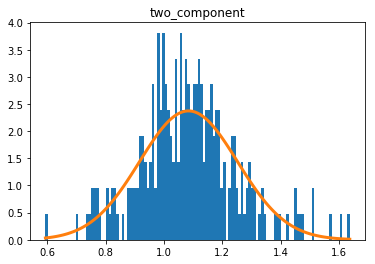

In [226]:
Evaluate_Model(rois.roi_4, models)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


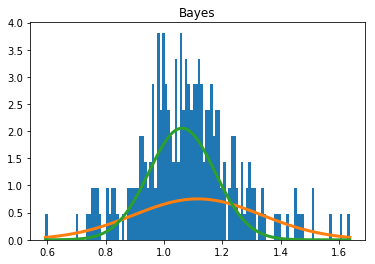

In [228]:
Evaluate_Model(rois.roi_4, mods)

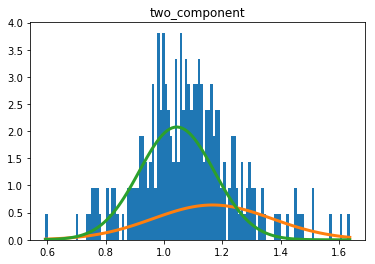

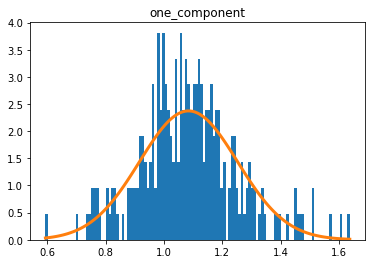

In [232]:
Evaluate_Model(rois.roi_4, mods)

In [18]:
def Evaluate_Model(roi, models, bins=None):
    '''
    Given an array of values and a dictionary of models, this script
    will generate a plot of the fitted distribution(s) from each 
    model (seperately) over the supplied data.
    
    roi -- an array, series or list values
    models -- a dict object of string label: (unfitted) sklearn.gaussian 
        model pairs
    bins -- Number of bins for the histogram.
        Passing None (default) sets bin to length(roi) / 2
    '''
    
    if type(roi) == np.ndarray or type(roi) == list:
        roi = pandas.Series(roi)
    plt.close()
    if not bins:
        bins = int(len(roi)/2)
    
    for label,model in models.items():
        mmod = model.fit(roi.values.reshape(-1,1))
        if mmod.n_components == 2:
            m1, m2 = mmod.means_
            w1, w2 = mmod.weights_
            c1, c2 = mmod.covariances_
            histdist = plt.hist(roi, bins, normed=True)
            plotgauss1 = lambda x: plt.plot(x,w1*mlab.normpdf(x,m1,np.sqrt(c1))[0], linewidth=3)
            plotgauss2 = lambda x: plt.plot(x,w2*mlab.normpdf(x,m2,np.sqrt(c2))[0], linewidth=3)
            plotgauss1(histdist[1])
            plotgauss2(histdist[1])
        elif mmod.n_components == 1:
            m1 = mmod.means_
            w1 = mmod.weights_
            c1 = mmod.covariances_
            histdist = plt.hist(roi, bins, normed=True)
            plotgauss1 = lambda x: plt.plot(x,w1*mlab.normpdf(x,m1,np.sqrt(c1))[0][0], linewidth=3)
            plotgauss1(histdist[1])
        plt.title(label)
        plt.show()

### Test Plot Probabilities

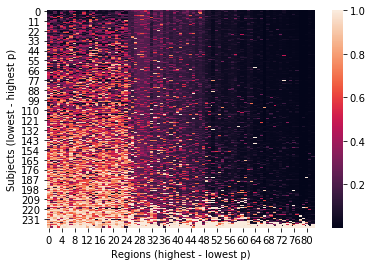

Index(['roi_37', 'roi_78', 'roi_42', 'roi_75', 'roi_19', 'roi_32', 'roi_72',
       'roi_58', 'roi_56', 'roi_31', 'roi_77', 'roi_15', 'roi_36', 'roi_17',
       'roi_81', 'roi_43', 'roi_76', 'roi_39', 'roi_38', 'roi_35', 'roi_33',
       'roi_1', 'roi_4', 'roi_71', 'roi_83', 'roi_34', 'roi_8', 'roi_63',
       'roi_54', 'roi_60', 'roi_47', 'roi_12', 'roi_3', 'roi_48', 'roi_82',
       'roi_40', 'roi_74', 'roi_24', 'roi_57', 'roi_51', 'roi_41', 'roi_30',
       'roi_14', 'roi_70', 'roi_21', 'roi_73', 'roi_23', 'roi_53', 'roi_11',
       'roi_13', 'roi_7', 'roi_45', 'roi_66', 'roi_69', 'roi_79', 'roi_67',
       'roi_59', 'roi_22', 'roi_62', 'roi_46', 'roi_68', 'roi_52', 'roi_49',
       'roi_16', 'roi_2', 'roi_27', 'roi_55', 'roi_5', 'roi_10', 'roi_29',
       'roi_80', 'roi_65', 'roi_20', 'roi_18', 'roi_61', 'roi_64', 'roi_9',
       'roi_25', 'roi_28', 'roi_44', 'roi_6', 'roi_50', 'roi_26'],
      dtype='object')

In [243]:
Plot_Probabilites(ecdfs)

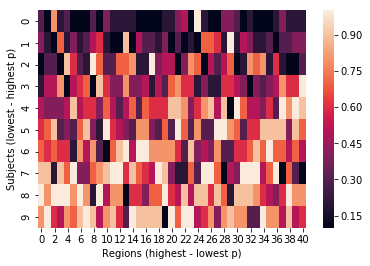

Index(['roi_2', 'roi_60', 'roi_46', 'roi_47', 'roi_48', 'roi_50', 'roi_52',
       'roi_53', 'roi_59', 'roi_61', 'roi_44', 'roi_62', 'roi_64', 'roi_65',
       'roi_66', 'roi_67', 'roi_68', 'roi_70', 'roi_45', 'roi_41', 'roi_20',
       'roi_36', 'roi_5', 'roi_6', 'roi_7', 'roi_8', 'roi_11', 'roi_13',
       'roi_14', 'roi_16', 'roi_75', 'roi_22', 'roi_25', 'roi_26', 'roi_27',
       'roi_28', 'roi_29', 'roi_33', 'roi_23', 'roi_72', 'roi_4'],
      dtype='object')

In [434]:
Plot_Probabilites(ecdfs)

In [19]:
def Plot_Probabilites(prob_matrix):
    '''
    Given the output matrix of Convert_ROI_values_to_Probabilities, will plot
    a heatmap of all probability values sorted in such a manner to demonstrate
    a progression of values.
    '''
    
    if type(prob_matrix) == np.ndarray:
        prob_matrix = pandas.DataFrame(prob_matrix)
        
    good_cols = [x for x in prob_matrix.columns if not all([x==0 for x in prob_matrix[x]])] 
    prob_matrix = prob_matrix[good_cols]
    
    plt.close()
    sorter = pandas.DataFrame(prob_matrix,copy=True)
    sorter.loc[:,'mean'] = prob_matrix.mean(axis=1)
    sorter2 = pandas.DataFrame(prob_matrix,copy=True)
    sorter2.loc['mean',:] = prob_matrix.mean(axis=0)
    forplot = prob_matrix.loc[sorter.sort_values('mean',axis=0,ascending=True).index
                        ][sorter2.sort_values('mean',axis=1,ascending=False).columns]
    sns.heatmap(forplot.values)
    plt.xlabel('Regions (highest - lowest p)')
    plt.ylabel('Subjects (lowest - highest p)')
    plt.show()
    
    return forplot.columns

### Testing Evaluate Probabilities

In [260]:
tdf = pandas.read_csv('/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/braak_stage_rois.csv')

In [283]:
tdf.count()

subject                  241
visit                    241
data_driven_1            241
data_driven_2            241
data_driven_3            241
data_driven_4            241
data_driven_5            241
schwarz_roi1             241
schwarz_stage1           241
schwarz_roi2             241
schwarz_stage2           241
schwarz_roi3             241
schwarz_stage3           241
schwarz_roi4             241
schwarz_stage4           241
schwarz_roi5             241
schwarz_stage5           241
schwarz_roi6             241
schwarz_stage6           241
cho_roi1                 241
cho_stage1               241
cho_roi2                 241
cho_stage2               241
cho_roi3                 241
cho_stage3               241
cho_roi4                 241
cho_stage4               241
cho_roi5                 241
cho_stage5               241
scholl_roi1              241
                        ... 
scholl_roi3              241
scholl_stage3            241
scholl_roi4              241
scholl_stage4 

In [269]:
scans = glob('/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/smoothed_ICA_regressed_scans/*')

In [276]:
scans[0]

'/home/users/jvogel/Science/ADNI_tau/template_space/tau_images/smoothed_ICA_regressed_scans/137_S_4482_v1_ICAregr.nii.gz'

In [280]:
sids = [x.split('scans/')[1].split('_v')[0] for x in scans]
visits = [x.split('scans/')[1].split('_')[3][-1] for x in scans]
ids = []
for i in range(len(sids)):
    ids.append(tdf[(tdf.subject==sids[i]) & (tdf.visit==int(visits[i]))].index[0])
ids

[149,
 103,
 205,
 54,
 93,
 195,
 132,
 123,
 8,
 152,
 6,
 25,
 87,
 144,
 37,
 107,
 219,
 159,
 231,
 191,
 10,
 130,
 1,
 154,
 57,
 199,
 172,
 133,
 118,
 211,
 222,
 197,
 236,
 237,
 138,
 177,
 50,
 167,
 212,
 62,
 175,
 21,
 157,
 143,
 131,
 11,
 17,
 69,
 66,
 213,
 115,
 147,
 134,
 127,
 60,
 171,
 24,
 141,
 33,
 108,
 39,
 226,
 239,
 200,
 72,
 227,
 153,
 169,
 70,
 31,
 136,
 208,
 192,
 35,
 4,
 188,
 114,
 183,
 142,
 225,
 82,
 224,
 196,
 223,
 215,
 203,
 163,
 71,
 83,
 113,
 155,
 58,
 112,
 95,
 18,
 166,
 13,
 94,
 137,
 180,
 20,
 74,
 106,
 151,
 176,
 97,
 164,
 156,
 161,
 45,
 229,
 240,
 182,
 86,
 49,
 145,
 40,
 160,
 218,
 63,
 0,
 42,
 207,
 90,
 75,
 117,
 120,
 26,
 30,
 186,
 77,
 32,
 56,
 238,
 135,
 48,
 55,
 220,
 179,
 98,
 148,
 67,
 209,
 129,
 235,
 189,
 194,
 102,
 78,
 124,
 111,
 96,
 128,
 181,
 2,
 14,
 46,
 73,
 16,
 228,
 100,
 89,
 230,
 204,
 80,
 79,
 146,
 116,
 158,
 59,
 52,
 85,
 27,
 202,
 162,
 198,
 193,
 61,
 170,
 1

In [286]:
dx = tdf.loc[ids,'DX_fill']
amyloid = tdf.loc[ids,'av45_status']
age = tdf.loc[ids,'AGE']
for series in [dx,amyloid,age]:
    series.index = range(len(series))


In [295]:
stats.pearsonr(age.dropna(),test_data[test_data.columns[0]])

(-0.037666003515243546, 0.56477187894682901)

In [306]:
test_data = rois.loc[age.dropna().index]
test_vars = {'dx': dx.dropna(), 'amyloid': amyloid.dropna(), 'age': age.dropna()}
jnk = Evaluate_Probabilities(test_data, test_vars, info='heavy', FDR='fdr_bh')

for dx, using ANOVA...
=============dx============
for dx, 0 regions were significant
[]



for amyloid, using t-test...
=============amyloid============
for amyloid, 0 regions were significant
[]



for age, using correlation...
=============age============
for age, 0 regions were significant
[]





In [20]:


def Evaluate_Probabilities(prob_matrix, to_test, alpha_threshold = 0.05, FDR=None, info='medium'):
    '''
    This script will quickly calculate significant (as defined by user)
    associations between all columns in a DataFrame or matrix and variables
    passed by the user. The script will try to guess the appropriate test to
    run. Depending on inputs, the script will display the number of 
    significant columns, which columns are significant and the alpha values;
    for each passed variable.
    Multiple comparisons correction is supported.
    
    prob_matrix -- a Subject x ROI matrix or DataFrame
    
    to_test -- a dict object of where values are columns, arrays or lists with
    the same length as prob_matrix, and keys are string labels IDing them.
    
    alpha_threshold -- determines what is significant. NOTE: If an argument is
    passed for FDR, alpha_threshold refers to Q, otherwise, it refers to p.
    
    FDR -- If no argument is passed (default), no multiple comparisons
    correction is performed. If the user desires multiple comparisons correction,
    the user can select the type by entering any of the string arguments described
    here: http://www.statsmodels.org/0.8.0/generated/statsmodels.sandbox.stats.multicomp.multipletests.html
    
    info -- Determines how much information the script will display upon
    completion. 
        light: script will only display the number of significant regions
        medium: script will also display which regions were significnat
        heavy: script will also display the alpha value for each region
    '''
        

    if info not in ['light','medium','heavy']:
        print('WARNING: a value of %s was passed for argument "info"'%(info))
        print('Script will proceed with minimal information displayed')
        print('in the future, please pass one of the following:')
        print('"light", "medium", "heavy"')
        info = 'light'
    if type(prob_matrix) == np.ndarray:
        prob_matrix = pandas.DataFrame(prob_matrix)
    good_cols = [x for x in prob_matrix.columns if not all([x==0 for x in prob_matrix[x]])] 
    prob_matrix = prob_matrix[good_cols]
    
    for label, var in to_test.items():
        if type(var) == np.ndarray or type(var) == list:
            var = pandas.Series(var)
        ps = []
        n_vals = len(np.unique(var))
        if n_vals < 7:
            vals = np.unique(var)
            if n_vals == 2:
                print('for %s, using t-test...'%(label))
                for col in prob_matrix.columns:
                    p = stats.ttest_ind(prob_matrix.loc[var==vals[0]][col],
                                        prob_matrix.loc[var==vals[1]][col])[-1]
                    ps.append(p)
            elif n_vals == 3:
                print('for %s, using ANOVA...'%(label))
                for col in prob_matrix.columns:
                    p = stats.f_oneway(prob_matrix.loc[var==vals[0]][col],
                                        prob_matrix.loc[var==vals[1]][col],
                                      prob_matrix.loc[var==vals[2]][col])[-1]
                    ps.append(p)
            elif n_vals == 4:
                print('for %s, using ANOVA...'%(label))
                for col in prob_matrix.columns:
                    p = stats.f_oneway(prob_matrix.loc[var==vals[0]][col],
                                        prob_matrix.loc[var==vals[1]][col],
                                      prob_matrix.loc[var==vals[2]][col],
                                      prob_matrix.loc[var==vals[3]][col])[-1]
                    ps.append(p)
            elif n_vals == 5:
                print('for %s, using ANOVA...'%(label))
                for col in prob_matrix.columns:
                    p = stats.f_oneway(prob_matrix.loc[var==vals[0]][col],
                                        prob_matrix.loc[var==vals[1]][col],
                                      prob_matrix.loc[var==vals[2]][col],
                                      prob_matrix.loc[var==vals[3]][col],
                                      prob_matrix.loc[var==vals[4]][col])[-1]
                    ps.append(p)
            elif n_vals == 6:
                print('for %s, using ANOVA...'%(label))
                for col in prob_matrix.columns:
                    p = stats.f_oneway(prob_matrix.loc[var==vals[0]][col],
                                        prob_matrix.loc[var==vals[1]][col],
                                      prob_matrix.loc[var==vals[2]][col],
                                      prob_matrix.loc[var==vals[3]][col],
                                      prob_matrix.loc[var==vals[4]][col],
                                       prob_matrix.loc[var==vals[4]][col])[-1]
                    ps.append(p)
        else:
            print('for %s, using correlation...'%(label))
            for col in prob_matrix.columns:
                p = stats.pearsonr(prob_matrix[col],var)[-1]
                ps.append(p)
        if not FDR:
            hits = [i for i in range(len(ps)) if ps[i] < alpha_threshold]
        else:
            correction = multipletests(ps,alpha_threshold,FDR)
            hits = [i for i in range(len(ps)) if correction[0][i]]
        
        print('=============%s============'%label)
        print('for %s, %s regions were significant'%(label,len(hits)))
        if info == 'medium':
            print(prob_matrix.columns[hits])
        if info == 'heavy':
            if not FDR:
                print([(prob_matrix.columns[i], ps[i]) for i in hits])
            else:
                print([(prob_matrix.columns[i], correction[1][i]) for i in hits])
        print('\n\n')
                  
    return ps

### testing Prepare_Inputs_for_ESM

In [81]:
#os.mkdir('/home/users/jvogel/Science/ADNI_tau/ESM_prep/testing_tmp')
prob_matrices = {'test_data': ecdfs}
ages = np.random.randint(60,90,10)
output_dir = '/home/users/jvogel/Science/ADNI_tau/ESM_prep/testing_tmp'
file_name = 'test'
conn_matrices = ['/home/users/jvogel/Science/scripts/ESM/connectivity_CMU60DSI/Matrix_ACP.mat']
conn_mat_names = ['Map']
conn_out_names = ['ACP']
Prepare_Inputs_for_ESM(prob_matrices, ages, output_dir, file_name, 
                           conn_matrices, conn_mat_names, conn_out_names)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [74]:
jnk = loadmat('/home/users/jvogel/Science/ADNI_tau/ESM_prep/testing_tmp/test')
jnk.keys()

dict_keys(['__header__', '__version__', '__globals__', 'test_data', 'ages'])

In [71]:
jnk

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Jun  1 13:09:06 2018',
 '__version__': '1.0',
 'ages': array([[60, 75, 61, 84, 79, 81, 70, 69, 82, 79]]),
 'test_data': array([[ 0.8,  0.3,  1. ,  0.6,  0.4,  0.5,  0.2,  0.7,  0.9,  0.1],
        [ 0.6,  0.2,  0.8,  0.7,  0.4,  0.9,  1. ,  0.5,  0.1,  0.3],
        [ 1. ,  0.5,  0.9,  0.7,  0.1,  0.8,  0.6,  0.3,  0.2,  0.4],
        [ 1. ,  0.1,  0.5,  0.3,  0.2,  0.4,  0.6,  0.9,  0.7,  0.8],
        [ 0.5,  1. ,  0.9,  0.8,  0.1,  0.6,  0.2,  0.4,  0.3,  0.7],
        [ 0.6,  0.2,  0.9,  0.3,  0.7,  0.8,  0.4,  0.5,  1. ,  0.1],
        [ 0.8,  0.1,  0.6,  0.3,  0.7,  0.9,  0.2,  0.4,  1. ,  0.5],
        [ 0.4,  0.1,  0.9,  1. ,  0.6,  0.5,  0.2,  0.8,  0.7,  0.3],
        [ 0.8,  0.4,  0.7,  1. ,  0.2,  0.9,  0.6,  0.3,  0.1,  0.5],
        [ 0.9,  0.4,  0.2,  0.8,  1. ,  0.1,  0.6,  0.3,  0.5,  0.7],
        [ 1. ,  0.2,  0.6,  0.3,  0.1,  0.9,  0.7,  0.8,  0.4,  0.5],
        [ 0.8,  0.1, 

In [80]:
def Prepare_Inputs_for_ESM(prob_matrices, ages, output_dir, file_name, 
                           conn_matrices = [], conn_mat_names = [], 
                           conn_out_names = [], figure = True):
    '''
    This script will convert data into a matfile compatible with 
    running the ESM, and will print outputs to be entered into
    ESM launcher script. The script will also adjust connectomes
    to accomodate missing (masked) ROIs.
    
    prob_matrices -- a dict object matching string labels to 
    probability matrices (pandas DataFrames). These will be 
    converted into a matlab structure. Columns with all 0s will be 
    removed automatically.
        NOTE: All prob_matrices should the same shape, and a 
        matching number of non-zero columns. If they do not, run the
        script separately for these matrices.
    
    ages -- an array the same length of prob_matrices that contains
    the age of each subject.
    
    output_dir -- an existing directory where all outputs will be
    written to
    
    file_name -- the name of the output matfile. Do not include a
    file extension
    
    conn_matrices -- a list of paths to matfiles or csvs containing
    connectomes that match the atlas used to intially extract data. 
    if your probability matrix does not have columns with 0s
    (because, for example, you used a mask), this argument can be
    left unchanged. Otherwise, the script will chop up the
    connectomes so they match the dimensions of the non-zero columns
    in the probability matrices.
        NOTE: passing this argument requires passing an argument for
        conn_out_names
        
    con_mat_names -- a list the same length of conn_matrices that 
    contains string labels
    
    '''

    if type(prob_matrices) != dict:
        raise IOError('prob_matrices must be a dict object')
    
    col_lens = []
    for lab, df in prob_matrices.items():
        good_cols = [y for y in df.columns if not all([x==0 for x in df[y]])]
        col_lens.append(len(good_cols))
        prob_matrices.update({lab: df[good_cols].values.T})
    if not all([x == col_lens[0] for x in col_lens]):
        raise IOError('all probability matrices entered must have the same # of non-zero columns')
    
    goodcols = [y for y in range(len(df.columns)) if not all([x==0 for x in df[df.columns[y]]])]
    
    if len(conn_matrices) > 0:
        if not len(conn_matrices) == len(conn_out_names):
            raise ValueError('equal length lists must be passed for all three conn_mat arguments')
        for i,mtx in enumerate(conn_matrices):
            if mtx[-3:] == 'csv':
                pandas.read_csv(mtx)
            elif mtx[-3:] == 'mat':
                connmat = loadmat(mtx)[conn_mat_names[i]]
            newmat = np.array([thing[goodcols] for thing in connmat[goodcols]])
            connmat[file_name] = newmat
            savemat(os.path.join(output_dir,conn_out_names[i]), connmat)
            print('new connecitity matrix size: for %s'%conn_out_names[i],newmat.shape)
            if figure:
                plt.close()
                sns.heatmap(newmat)
                plt.show()

    if type(ages) == np.ndarray or type(ages) == list:
        ages = pandas.Series(ages)
    if len(ages.dropna()) != len(df):
        raise ValueError('length mismatch between "ages" and prob_matrices. Does "ages" have NaNs?')
    prob_matrices.update({'ages': ages.values})
    fl_out = os.path.join(output_dir,file_name)
    savemat(fl_out,prob_matrices)
    print('ESM input written to',fl_out)
    print('===inputs:===')
    for x in prob_matrices.keys():
        print(x)
    if len(conn_matrices) > 0:
        for i in range(len(conn_matrices)):
            print('===connectivity matrices===')
            print(os.path.join(output_dir,conn_out_names[i]), conn_mat_names[i])
    

In [ ]:
def get_results(mat, sids, save=True, labels = None, lit = False):

    if not lit:
        res = pandas.DataFrame(index = sids)
        for i in range(len(mat['ref_pattern'][0])):
            # Model fits
            sid = sids[i]
            r,p = stats.pearsonr(mat['ref_pattern'][:,i], mat['Final_solutions'][:,i])
            res.loc[sid,'model_r'] = r
            res.loc[sid,'model_r2'] = r**2
        res.loc[:, 'model_RMSE'] = mat['Final_RMSEs'].flatten()
        res.loc[:, 'model_eval'] = mat['Final_CORRs'].flatten()

        if save:
            # params
            res.loc[:, 'beta'] = mat['Final_parameters'][0,:].flatten()
            res.loc[:, 'delta'] = mat['Final_parameters'][1,:].flatten()
            res.loc[:, 'sigma'] = mat['Final_parameters'][2,:].flatten()

            # other
            res.loc[:, 'ref_age'] = mat['AGEs'].flatten()
            res.loc[:, 'times'] = mat['Final_times'].flatten()
            res.loc[:, 'Onset_age'] = mat['ONSETS_est'].flatten()

        print('average r2 = ', res.model_r2.mean())
        print('average RMSE =', res.model_RMSE.mean())
        print('average eval =', res.model_eval.mean())

        if type(labels) != type(None):
            print('model identfied the following epicenters')
            for l in mat['models'][0,0][0][0]:
                print(labels.iloc[l-1]['label'])

        if save:
            return res
        
    else:
        res = pandas.DataFrame(index = sids)
        for i in range(len(mat['ref_pattern'][0])):
            # Model fits
            sid = sids[i]
            r,p = stats.pearsonr(mat['ref_pattern'][:,i], mat['model_solutions0'][:,i])
            res.loc[sid,'model_r'] = r
            res.loc[sid,'model_r2'] = r**2
        res.loc[:, 'model_RMSE'] = mat['model_RMSEs0'].flatten()
        res.loc[:, 'model_eval'] = mat['model_CORRs0'].flatten()

        if save:
            # params
            res.loc[:, 'beta'] = mat['model_parameters0'][0,:].flatten()
            res.loc[:, 'delta'] = mat['model_parameters0'][1,:].flatten()
            res.loc[:, 'sigma'] = mat['model_parameters0'][2,:].flatten()

            # other
            res.loc[:, 'ref_age'] = mat['AGEs'].flatten()
            res.loc[:, 'times'] = mat['model_times0'].flatten()
            #res.loc[:, 'Onset_age'] = mat['ONSETS_est'].flatten()

        print('average r2 = ', res.model_r2.mean())
        print('average RMSE =', res.model_RMSE.mean())
        print('average eval =', res.model_eval.mean())

        #if type(labels) != type(None):
        #    print('model identfied the following epicenters')
        #    for l in mat['models'][0,0][0][0]:
        #        print(labels.iloc[l-1]['label'])

        if save:
            return res